# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from nscl_dataset import NSCLDataSet

cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

'pynvml module not found, please install pynvml'

In [68]:
ds = NSCLDataSet()

In [69]:
next(iter(ds))[0].shape

torch.Size([3, 512, 512])

# Defining datasets (train/validation) 

In [70]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainSet, valSet = random_split(NSCLDataSet(transform=preprocess), [0.8, 0.2])
dataloaders = {
    "train": torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=4)
}

class_names = ["Adenocarcinoma", "Small Cell Carcinoma", "Large Cell Carcinoma", "Squamous Cell Carcinoma"]
num_classes = len(class_names)
dataset_sizes = {"train": len(trainSet),"val": len(valSet)}

# Defining model 

In [71]:

resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# freeze all layers but last
for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(class_names))

#modules = []
#modules.append(resnet)
#modules.append(nn.Linear(1024, 512))
#modules.append(nn.ReLU())
#modules.append(nn.Linear(512, 128))
#modules.append(nn.ReLU())
#modules.append(nn.Linear(128,len(class_names) ))
#modules.append(nn.Softmax(1))
#
#resnet = nn.Sequential(*modules)
resnet.to(device)

Using cache found in /dhc/home/tobias.fiedler/.cache/torch/hub/pytorch_vision_v0.10.0
/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

# Setup training

In [72]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                if idx % 200 == 0:
                    print(f"Batch {idx}/{len(dataloaders[phase])}")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                try:
                    running_loss += loss.item() * inputs.size(0)
                    _, labels_index = torch.max(labels.data, 1)
                    running_corrects += torch.sum(preds ==labels_index)
                    
                except RuntimeError as e:
                    print("RuntimeError was thrown while calculating statistics: ", e) 
                #if idx==6050:
                #    print("preds",preds)
                #    print()
                #    comparison = preds == labels.data
                #    #torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Define training parameters

In [73]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run training

In [74]:
resnet = train_model(resnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 1.1237 Acc: 0.6445
Batch 0/190
val Loss: 1.0880 Acc: 0.6564

Epoch 1/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 1.0877 Acc: 0.6564
Batch 0/190
val Loss: 1.0876 Acc: 0.6564

Epoch 2/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 1.0875 Acc: 0.6564
Batch 0/190
val Loss: 1.0875 Acc: 0.6564

Epoch 3/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 1.0874 Acc: 0.6564
Batch 0/190
val Loss: 1.0874 Acc: 0.6564

Epoch 4/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 1.0874 Acc: 0.6564
Batch 0/190
val Loss: 1.0874 Acc: 0.6564

Epoch 5/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 1.0873 Acc: 0.6564
Batch 0/190
val Loss: 1.0874 Acc: 0.6564

Training complete in 9m 14s
Best val Acc: 0.656353


# Evaluation

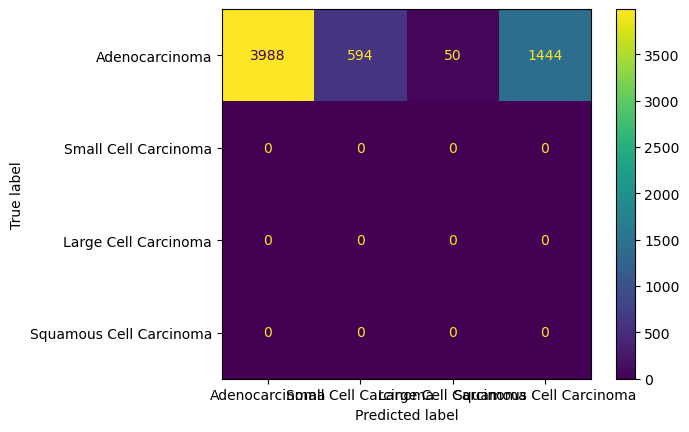

F1-score: 0.7925278219395867


In [75]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

y_true = np.array([])
y_pred = np.array([])
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs.cpu(), 1)
        _, labels = torch.max(classes.cpu(), 1)
        y_true = np.concatenate((y_true, preds))
        y_pred = np.concatenate((y_pred, labels))
        
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=class_names)
disp.plot()
plt.show()
print("F1-score:",f1_score(y_true, y_pred, average="weighted") )

# Debugging

In [76]:
import torch
outputs = torch.Tensor([[0,0,1], [1,0,0], [0,1,0]])
_, preds = torch.max(outputs, 1)
labels = torch.Tensor([1, 0, 1])

print("Predictions", preds)
print("Labels", labels)

comparison = preds == labels
print("Comparison", comparison)

print("Sum", torch.sum(preds == labels))

Predictions tensor([2, 0, 1])
Labels tensor([1., 0., 1.])
Comparison tensor([False,  True,  True])
Sum tensor(2)
